# Hello and welcome to the gFexComparison !
The name of the game is attempting to find matching events between dumped data and the decoded data on tier0. 

This notebook assumes that you have already run `python3 get_dumped_data_time.py -r 439798` in your terminal to find your time stamps and therefore corresponding lumiblock. 

You will need to return to your terminal to run the bytestream decoder over all of the files in the corresponding lumiblock.

I have written two scripts to make this easier for you

1. Please copy them from WorkDirgFexCompare/gfex_dump_to_tier0/scripts to WorkDirgFexCompare. 

2. Run the setup script with source setup_bytestream.sh 

3. Modify the runDecoder.sh script to have the run number and lumiblock number you are interested in

4. Run the decoding scrcipt with source runDecoder.sh

Once you have run the decoder script, you can run the event matching script!

1. Please move to WorkDirgFexCompare/gfex_dump_to_tier0

2. Run the setup script with source setup_filematch.sh

3. Run the matching script with python3 find_matching_events.py -r 439798 -l 701 (replacing with your preffered run number and lumiblock number)


### Please modify your working directory, run number and lumiblock here $\downarrow $

In [76]:
# runNumber = 439798
# lumiNumber = 701 

# runNumber = 440543
# lumiNumber = 1235  

# runNumber = 437522
# lumiNumber = 122 
# lumiNumber = 123

runNumber = "all"
lumiNumber = "all"

In [77]:
import sys,os,glob,uuid
import numpy as np
import pandas as pd
import utils as utils 
import csv
import math
import matplotlib.pyplot as plt
import os

In [78]:
#lets import the file we generated from running find_matching_events.py to make some plots!
if isinstance(runNumber, str): file = "CSVFiles_forMatchingEvents/AllDataTogether/all.csv"
elif isinstance(lumiNumber, int): file = "CSVFiles_forMatchingEvents/AOD_and_dump_r"+str(runNumber)+"_l"+str(lumiNumber).zfill(4)+".csv"
else: file = "CSVFiles_forMatchingEvents/CombineRun"+ str(runNumber) +"/AOD_and_dump_r" + str(runNumber)+"_all.csv"
events_file = pd.read_csv(file)
keys = list(events_file.keys())
matching_events = {}
for k in keys:
    if isinstance(events_file[k][0], str): #if 2d list then we need to split the string for each event into a list and convert elements to int
        strings = [list(x.replace('[','').replace(']','').split(", ")) for x in events_file[k]]
        matching_events[k]=[list( map(int,i) ) for i in strings] 
    else: matching_events[k]=[int(i) for i in events_file[k]]  #if 1d then we just want the values as ints
        
isExist = os.path.exists("ComparisonPlots/" + str(runNumber) )
if not isExist:os. makedirs("ComparisonPlots/" + str(runNumber) )

Fill some easy access arrays of what we think we are going to want to plot

Assumptions made:

in dumped data
- lead_g = leading gfex SR jet
- sub_g = subleading gfex SR jet
- l = left side of the fpga
- r = right side of the fpga
it will be easiest if we can 

in AOD data
- SRTobEt is the energy of the SR TOB
- the ordering of the array is: [lead_g_l_a, sub_g_l_a, lead_g_r_a, sub_g_r_a, lead_g_l_b, sub_g_l_b, lead_g_r_b, sub_g_r_b, lead_ g_l_c, sub_g_l_c, lead_g_r_c, sub_g_r_c]

In [79]:
#naming conventions (for our plotting mostly!)
middle_string = "leading gjet in "
fpga_array_sides = {
    "lead_g_l_a" : middle_string + "left FPGA A",
    "sub_g_l_a" : "sub"+ middle_string +"left FPGA A",
    "lead_g_r_a" : middle_string + "right FPGA A",
    "sub_g_r_a" : "sub"+ middle_string +"right FPGA A",
    "lead_g_l_b" : middle_string + "left FPGA B",
    "sub_g_l_b" : "sub"+ middle_string +"left FPGA B",
    "lead_g_r_b" : middle_string + "right FPGA B",
    "sub_g_r_b" : "sub"+ middle_string +"right FPGA B",
    "lead_g_l_c" : middle_string + "left FPGA C",
    "sub_g_l_c" : "sub"+ middle_string +"left FPGA C",
    "lead_g_r_c" : middle_string + "right FPGA C",
    "sub_g_r_c" : "sub"+ middle_string +"right FPGA C", 
}
order_of_fpga_array = list(fpga_array_sides.keys())
num_events = len(matching_events["AOD_SRTobEt"])

LR_fpga_array_sides = {
    "lead_g_l_a" : middle_string + "left FPGA A",
    "lead_g_r_a" : middle_string + "right FPGA A",
    "lead_g_l_b" : middle_string + "left FPGA B",
    "lead_g_r_b" : middle_string + "right FPGA B",
    "lead_g_l_c" : middle_string + "left FPGA C",
    "lead_g_r_c" : middle_string + "right FPGA C",
}
order_of_LR_fpga_array = list(LR_fpga_array_sides.keys())

### Okay now we can try to plot the variables to make comparisons to what we see between events


In [157]:
def make_compare(p, size): #p = property, size = LR or SR
    if size == "LR": length = len(order_of_LR_fpga_array[0:4])#limit to the first 6 elements in this fpga array, so we can skip interacting with FPGA C
    else: length = len(order_of_fpga_array[0:8])#limit to the first 8 elements in this fpga array, so we can skip interacting with FPGA C
    for i in range(length): 
        if size == "LR": 
            fpga_side = order_of_LR_fpga_array[i]
            title = p + " " + LR_fpga_array_sides[fpga_side] + " comparing AOD \n and Dumped "+size+" TOB data for events in run " + str(runNumber)
        else: 
            fpga_side = order_of_fpga_array[i]
            title = p + " " + fpga_array_sides[fpga_side] + " comparing AOD \n and Dumped "+size+" TOB data for events in run " + str(runNumber)
        fig, ax = plt.subplots()
        if "Eta" in p:
            ax.axvline(x=7.5, color = 'black', ls='--', lw=2)
            ax.axvline(x=13.5, color = 'black', ls='--', lw=1)
            ax.axvline(x=19.5, color = 'black', ls='--', lw=2)
            ax.axvline(x=25.5, color = 'black', ls='--', lw=1)
            ax.axvline(x=31.5, color = 'black', ls='--', lw=2)
            plt.xlim([3, 39])
        aod_events = [x[i] for x in matching_events["AOD_"+size+"Tob" + p]]
        dump_events = [x[i] for x in matching_events["Dump_"+size+"Tob" + p]]
        ax.scatter(aod_events , dump_events)
        ax.axline((0, 0), slope=1)
        plt.grid(True)
        plt.title(title, fontsize=15)
        plt.xlabel("Decoded Tier0 Data", fontsize=15)
        plt.ylabel("Dumped TOB Data", fontsize=15)
        fig.savefig("ComparisonPlots/" + str(runNumber) +"/" + p + '_'+ size +':'+order_of_fpga_array[i], bbox_inches='tight', dpi=300)
    return 

def make_ratio_compare(p, size): #p = property, size = LR or SR
    if size == "LR": length = len(order_of_LR_fpga_array[0:4])#limit to the first 6 elements in this fpga array, so we can skip interacting with FPGA C
    else: length = len(order_of_fpga_array[0:8])#limit to the first 8 elements in this fpga array, so we can skip interacting with FPGA C
    for i in range(length): 
        if size == "LR": 
            fpga_side = order_of_LR_fpga_array[i]
            title = "Ratio of "+ p + " " + LR_fpga_array_sides[fpga_side] + " comparing AOD \n and Dumped "+size+" TOB data for events in run " + str(runNumber)
        else: 
            fpga_side = order_of_fpga_array[i]
            title = "Ratio of "+p + " " + fpga_array_sides[fpga_side] + " comparing AOD \n and Dumped "+size+" TOB data for events in run " + str(runNumber)
        fig, ax = plt.subplots()
        if "Eta" in p:
            ax.axvline(x=7.5, color = 'black', ls='--', lw=2)
            ax.axvline(x=13.5, color = 'black', ls='--', lw=1)
            ax.axvline(x=19.5, color = 'black', ls='--', lw=2)
            ax.axvline(x=25.5, color = 'black', ls='--', lw=1)
            ax.axvline(x=31.5, color = 'black', ls='--', lw=2)
            plt.xlim([3, 39])
        aod_events = np.array([x[i] for x in matching_events["AOD_"+size+"Tob" + p]], dtype=float)
        dump_events = np.array([x[i] for x in matching_events["Dump_"+size+"Tob" + p]], dtype=float)
        ratio = np.divide(aod_events, dump_events , out=np.ones_like(aod_events), where=dump_events!=0)
        ax.scatter(aod_events, ratio, label=fpga_side)
        plt.grid(True)
        plt.title(title, fontsize=15)
        plt.xlabel( p + units + " from AOD data", fontsize=15)
        plt.ylabel("Ratio of Dumped TOB Data \n to Decoded Tier0 Data", fontsize=15)
        fig.savefig("ComparisonPlots/" + str(runNumber) +"/RatioPlot_" + p + '_'+ size +':'+order_of_fpga_array[i], bbox_inches='tight', dpi=300)
    return 


def make_compare_same_plot(p, size, logy=False, logx=False):    
    fig, ax = plt.subplots()
    if p == "Eta":
        ax.axvline(x=7.5, color = 'black', ls='--', lw=2)
        ax.axvline(x=13.5, color = 'black', ls='--', lw=1)
        ax.axvline(x=19.5, color = 'black', ls='--', lw=2)
        ax.axvline(x=25.5, color = 'black', ls='--', lw=1)
        ax.axvline(x=31.5, color = 'black', ls='--', lw=2)
        plt.xlim([3, 39])
    if size == "LR": length = len(order_of_LR_fpga_array[0:4])#limit to the first 6 elements in this fpga array, so we can skip interacting with FPGA C
    else: length = len(order_of_fpga_array[0:8])#limit to the first 8 elements in this fpga array, so we can skip interacting with FPGA C
    for i in range(length): 
        if size == "LR": fpga_side = order_of_LR_fpga_array[i]
        else: fpga_side = order_of_fpga_array[i]
        aod_events = [x[i] for x in matching_events["AOD_"+size+"Tob" + p]]
        dump_events = [x[i] for x in matching_events["Dump_"+size+"Tob" + p]]
        ax.scatter(aod_events , dump_events, label=fpga_side)
    if p == "Et": units = " counts"
    else: units = " index"
    title = p + units + " for all FPGAs and sides comparing AOD \n and Dumped "+size+" TOB data for events in run " + str(runNumber)
    plt.title(title, fontsize=15)
    ax.axline((0, 0), slope=1)
    plt.grid(True)
    if logy: ax.set_yscale('log')
    if logx: ax.set_xscale('log')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.xlabel("Decoded Tier0 Data", fontsize=15)
    if p == "Et": 
        plt.xlim([0, 3600])
        plt.ylim([0, 3600])
    plt.ylabel("Dumped TOB Data", fontsize=15)
    fig.savefig("ComparisonPlots/"+ str(runNumber) +"/" + p + '_'+ size + ':all_sides', bbox_inches='tight', dpi=300)
    return

def make_compare_ratio_same_plot(p, size, logy=False, logx=False):    
    fig, ax = plt.subplots()
    if p == "Eta":
        ax.axvline(x=7.5, color = 'black', ls='--', lw=2)
        ax.axvline(x=13.5, color = 'black', ls='--', lw=1)
        ax.axvline(x=19.5, color = 'black', ls='--', lw=2)
        ax.axvline(x=25.5, color = 'black', ls='--', lw=1)
        ax.axvline(x=31.5, color = 'black', ls='--', lw=2)
        plt.xlim([3, 39])
    if size == "LR": length = len(order_of_LR_fpga_array[0:4])#limit to the first 6 elements in this fpga array, so we can skip interacting with FPGA C
    else: length = len(order_of_fpga_array[0:8])#limit to the first 8 elements in this fpga array, so we can skip interacting with FPGA C
    for i in range(length): 
        if size == "LR": fpga_side = order_of_LR_fpga_array[i]
        else: fpga_side = order_of_fpga_array[i]
        aod_events = np.array([x[i] for x in matching_events["AOD_"+size+"Tob" + p]], dtype=float)
        dump_events = np.array([x[i] for x in matching_events["Dump_"+size+"Tob" + p]], dtype=float)
        ratio = np.divide(aod_events, dump_events , out=np.ones_like(aod_events), where=dump_events!=0)
        ax.scatter(aod_events , ratio, label=fpga_side)
    if p == "Et": units = " counts"
    else: units = " index"
    title = "Ratio of " + p + units + " for all FPGAs and sides comparing AOD \n and Dumped "+size+" TOB data for events in run " + str(runNumber)
    plt.title(title, fontsize=15)
    plt.grid(True)
    if logy: ax.set_yscale('log')
    if logx: ax.set_xscale('log')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.xlabel( p + units + " from AOD data" , fontsize=15)
    plt.ylabel("Ratio of Dumped TOB Data \n to Decoded Tier0 Data", fontsize=15)
    fig.savefig("ComparisonPlots/"+ str(runNumber) +"/RatioPlot_" + p + '_'+ size + ':all_sides', bbox_inches='tight', dpi=300)
    return

def plot_2d(event,size):
    fig, ax = plt.subplots()
    ax.axvline(x=7.5, color = 'black', ls='--', lw=2)
    ax.axvline(x=13.5, color = 'black', ls='--', lw=1)
    ax.axvline(x=19.5, color = 'black', ls='--', lw=2)
    ax.axvline(x=25.5, color = 'black', ls='--', lw=1)
    ax.axvline(x=31.5, color = 'black', ls='--', lw=2)
    plt.xlim([3, 39])
    event_number = matching_events["AOD_L1ID"][event] #want to use full L1ID in title! 
    et_aod = matching_events["AOD_"+size+"TobEt"]
    eta_aod = matching_events["AOD_"+size+"TobEta"]
    phi_aod = matching_events["AOD_"+size+"TobPhi"]
    et_dump = matching_events["Dump_"+size+"TobEt"]
    eta_dump = matching_events["Dump_"+size+"TobEta"]
    phi_dump = matching_events["Dump_"+size+"TobPhi"]
    
    array_colors = [item for sublist in [et_aod[event], et_dump[event]] for item in sublist] #make a stacked array of both et's for the data, so the color bar is complete
    vmin = np.min(array_colors)
    vmax = np.max(array_colors)
    if size == "LR": 
        im2 = ax.scatter(eta_dump[event], phi_dump[event],s=100, vmin=vmin, vmax=vmax, c=et_dump[event],cmap="jet", marker="o", label="Dump Data")
        im1 = ax.scatter(eta_aod[event], phi_aod[event], s=110, vmin=vmin, vmax=vmax, c=et_aod[event], cmap="jet", marker="d", label="AOD Data")
    else: 
        im2 = ax.scatter(eta_dump[event], phi_dump[event], vmin=vmin, vmax=vmax, c=et_dump[event],cmap="jet", marker='.', label="Dump Data")
        im1 = ax.scatter(eta_aod[event], phi_aod[event], vmin=vmin, vmax=vmax, c=et_aod[event], cmap="jet", marker='d', label="AOD Data")
    
    plt.colorbar(im1, label= size +" Jet ET (counts)",  ax=ax)
    plt.legend(bbox_to_anchor=(1.12, 1.05))
    plt.grid(True)
    plt.xlabel("Eta (index)", fontsize=15)
    plt.ylabel("Phi (index)", fontsize=15)
    title = "Event display for " + size + " jets \n for event " + str(event_number)
    plt.title(title, fontsize=20)
    fig.savefig("ComparisonPlots/" + str(runNumber) +"/event" + str(event_number) + '_' + size +'_eventdisplay',bbox_inches='tight', dpi=300)
    
def plot_lr_sr_2d(event):
    fig, ax = plt.subplots()
    ax.axvline(x=7.5, color = 'black', ls='--', lw=2)
    ax.axvline(x=13.5, color = 'black', ls='--', lw=1)
    ax.axvline(x=19.5, color = 'black', ls='--', lw=2)
    ax.axvline(x=25.5, color = 'black', ls='--', lw=1)
    ax.axvline(x=31.5, color = 'black', ls='--', lw=2)
    plt.xlim([3, 39])
    event_number = matching_events["AOD_L1ID"][event] #want to use full L1ID in title! 
    et_aod = matching_events["AOD_SRTobEt"]
    eta_aod = matching_events["AOD_SRTobEta"]
    phi_aod = matching_events["AOD_SRTobPhi"]
    et_dump = matching_events["Dump_SRTobEt"]
    eta_dump = matching_events["Dump_SRTobEta"]
    phi_dump = matching_events["Dump_SRTobPhi"]
    et_aod_lr = matching_events["AOD_LRTobEt"]
    eta_aod_lr = matching_events["AOD_LRTobEta"]
    phi_aod_lr = matching_events["AOD_LRTobPhi"]
    et_dump_lr = matching_events["Dump_LRTobEt"]
    eta_dump_lr = matching_events["Dump_LRTobEta"]
    phi_dump_lr = matching_events["Dump_LRTobPhi"]
    
    array_colors = [item for sublist in [et_aod[event], et_dump[event],et_aod_lr[event], et_dump_lr[event]] for item in sublist] #make a stacked array of both et's for the data, so the color bar is complete
    vmin = np.min(array_colors)
    vmax = np.max(array_colors)
    
    im2 = ax.scatter(eta_dump[event], phi_dump[event], vmin=vmin, vmax=vmax, c=et_dump[event], cmap="jet", marker=".", label="SR Dump Data")
    im4 = ax.scatter(eta_dump_lr[event], phi_dump_lr[event], s=100, vmin=vmin, vmax=vmax, c=et_dump_lr[event], cmap="jet", marker="o", label="LR Dump Data")
    im1 = ax.scatter(eta_aod[event], phi_aod[event], vmin=vmin, vmax=vmax, c=et_aod[event], cmap="jet", marker="d", label="SR AOD Data")
    im3 = ax.scatter(eta_aod_lr[event], phi_aod_lr[event], s=110, vmin=vmin, vmax=vmax, c=et_aod_lr[event], cmap="jet", marker="d", label="LR AOD Data")
    
    plt.colorbar(im1, label="Jet ET (counts)",  ax=ax)
    plt.legend(bbox_to_anchor=(1.2, 1.05))
    plt.grid(True)
    plt.xlabel("Eta (index)", fontsize=15)
    plt.ylabel("Phi (index)", fontsize=15)
    title = "Event display for event " + str(event_number)
    plt.title(title, fontsize=20)
    fig.savefig("ComparisonPlots/" + str(runNumber) +"/event" + str(event_number) + '_eventdisplay_LRandSR',bbox_inches='tight', dpi=300)

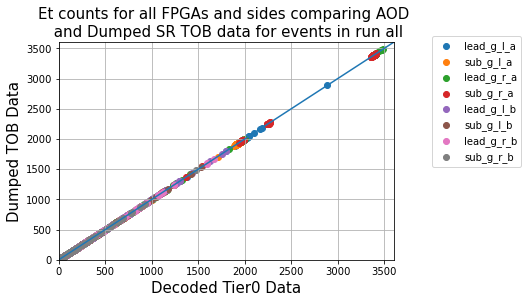

In [158]:
make_compare_same_plot("Et", "SR")

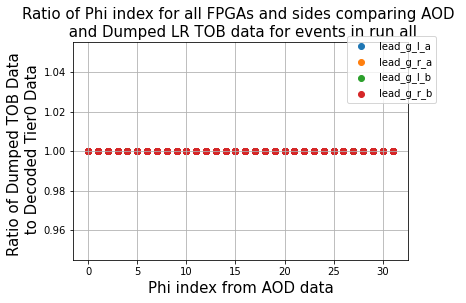

In [163]:
make_compare_ratio_same_plot("Phi", "LR")

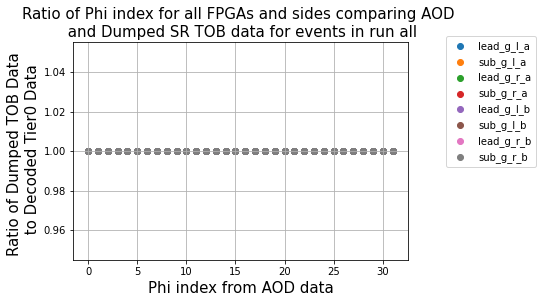

In [164]:
make_compare_ratio_same_plot("Phi", "SR")

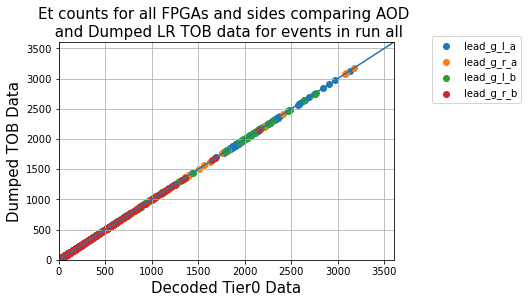

In [123]:
make_compare_same_plot("Et", "LR")

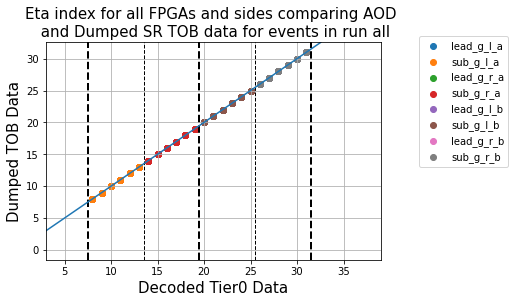

In [124]:
make_compare_same_plot("Eta", "SR")

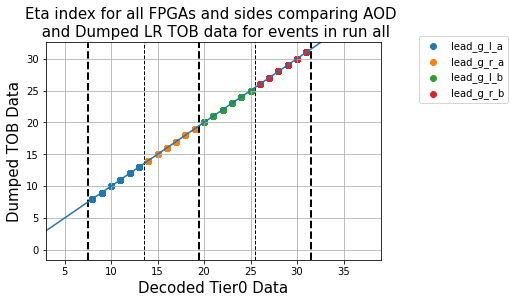

In [125]:
make_compare_same_plot("Eta", "LR")

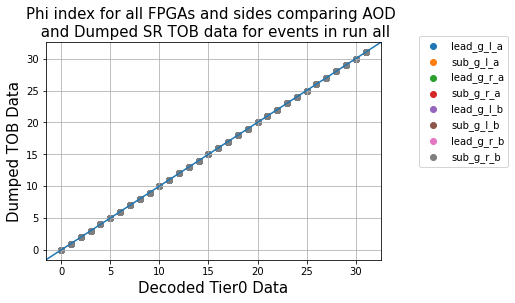

In [126]:
make_compare_same_plot("Phi", "SR")

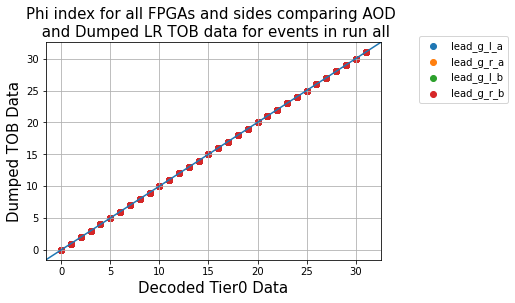

In [127]:
make_compare_same_plot("Phi", "LR")

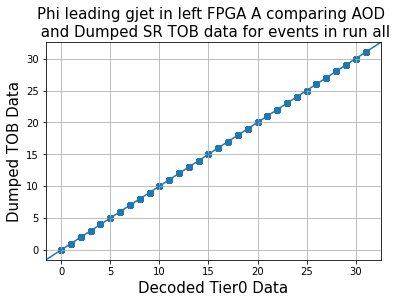

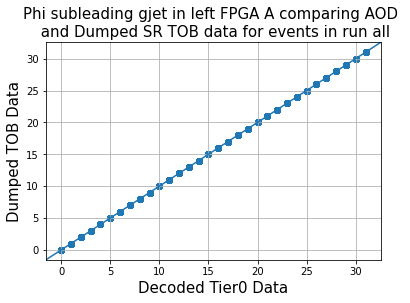

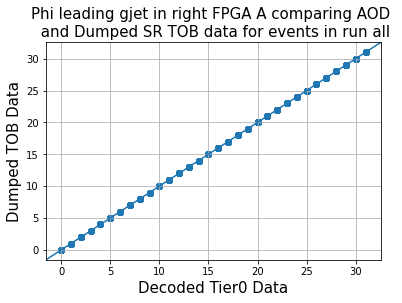

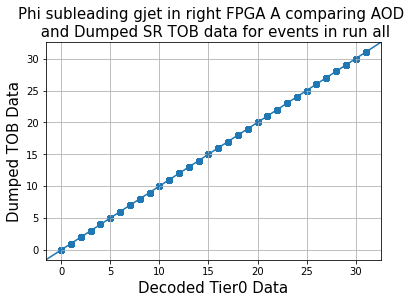

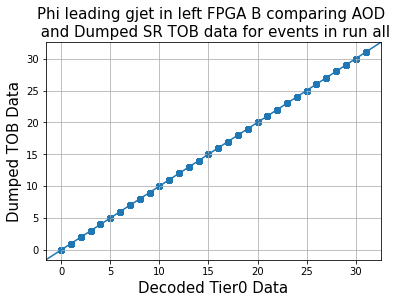

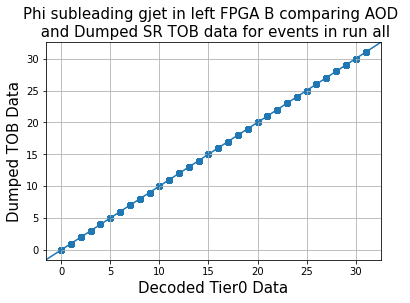

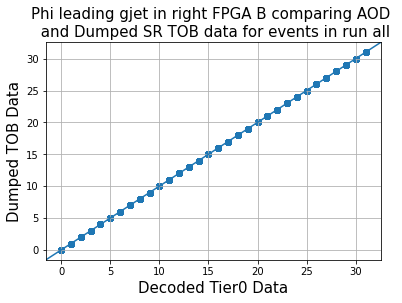

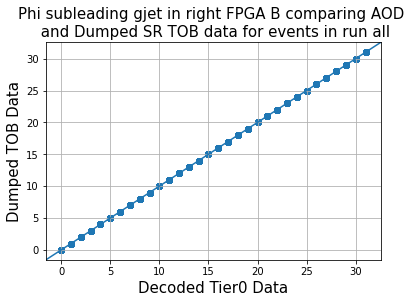

In [128]:
make_compare("Phi", "SR")

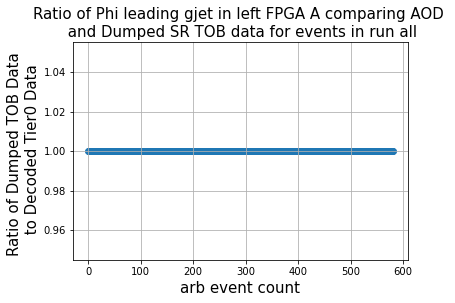

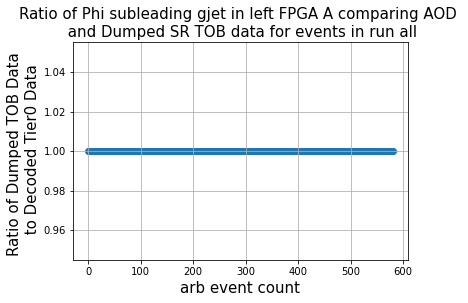

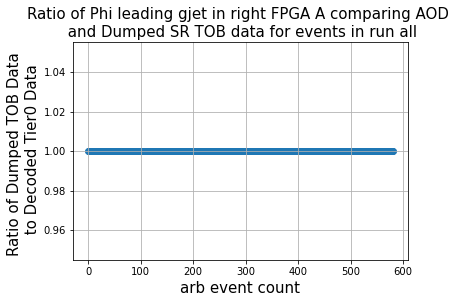

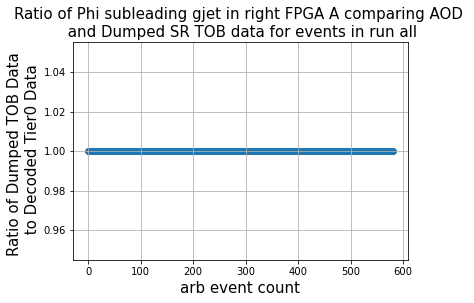

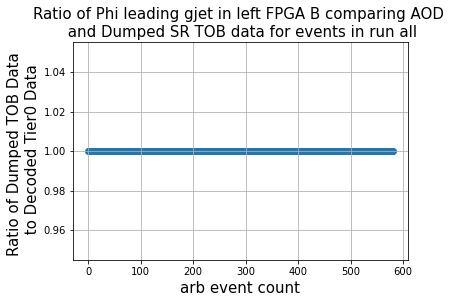

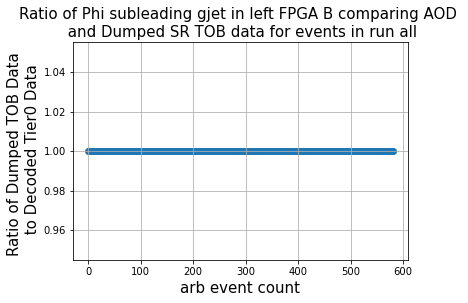

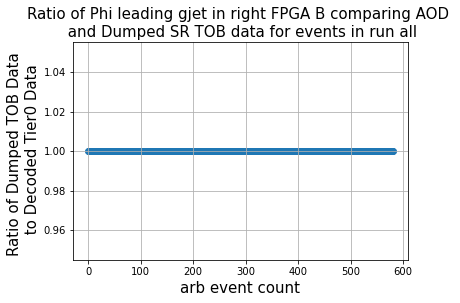

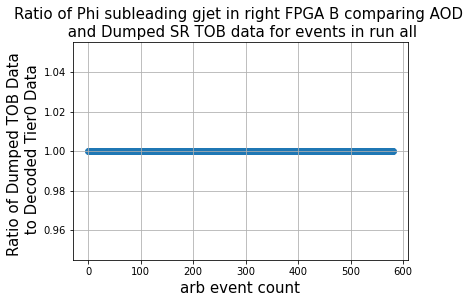

In [135]:
make_ratio_compare("Phi", "SR")

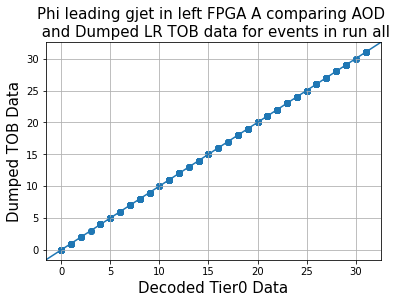

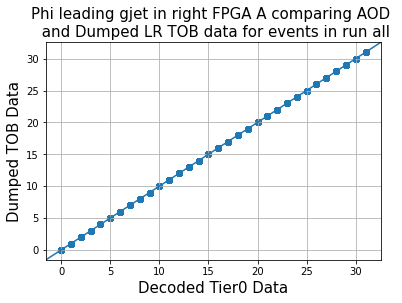

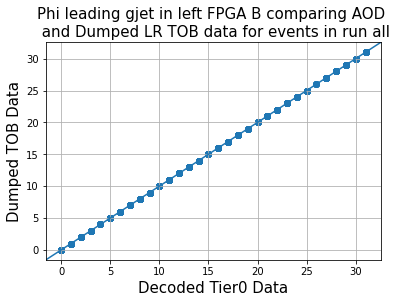

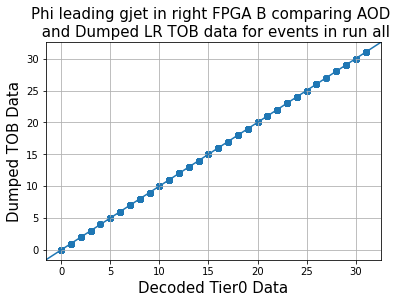

In [88]:
make_compare("Phi", "LR")

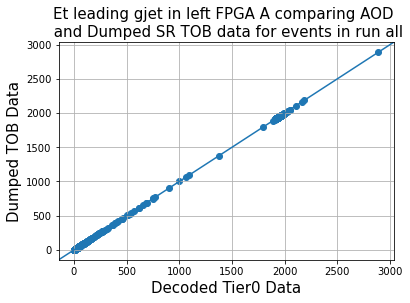

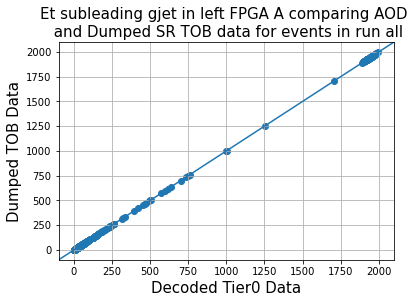

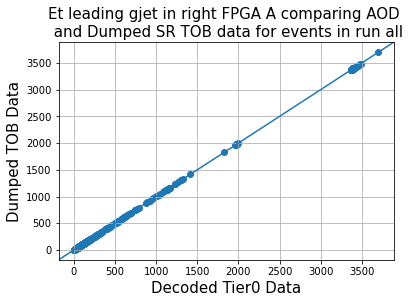

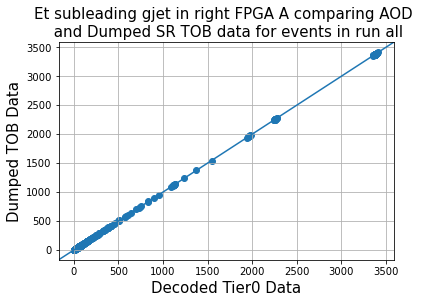

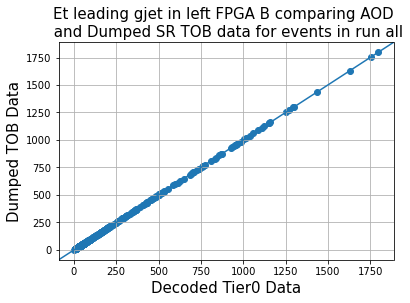

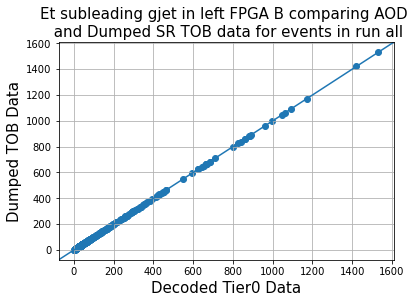

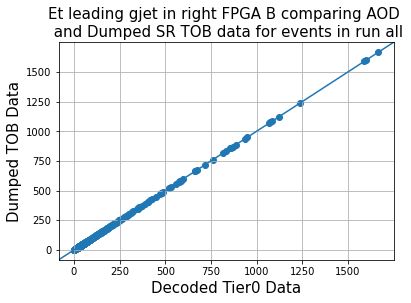

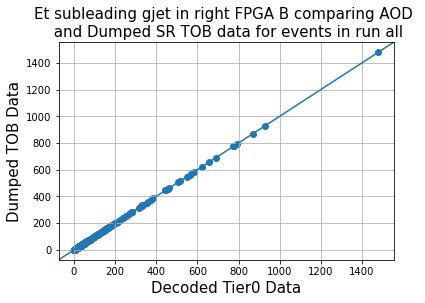

In [89]:
make_compare("Et", "SR")

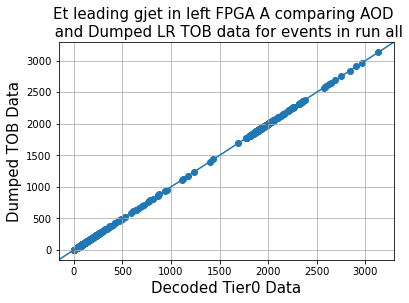

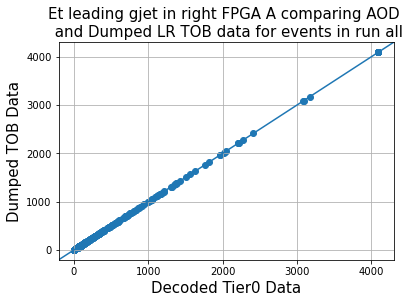

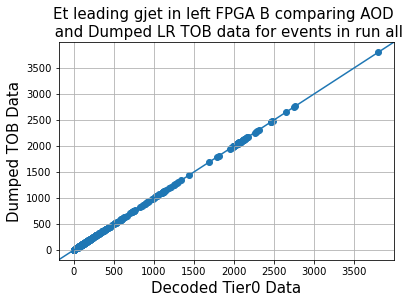

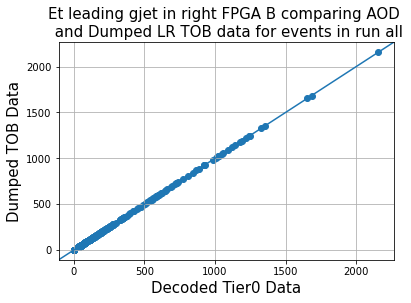

In [90]:
make_compare("Et", "LR")

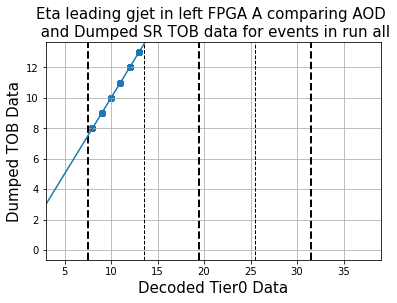

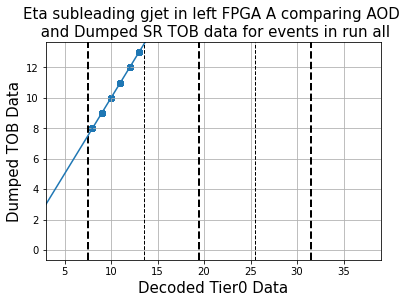

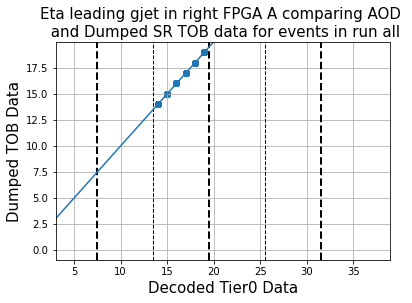

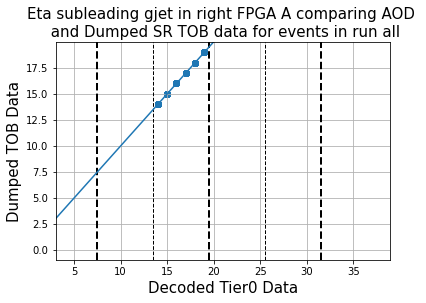

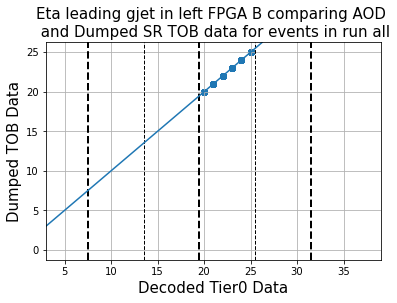

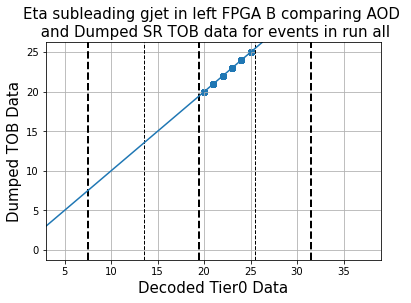

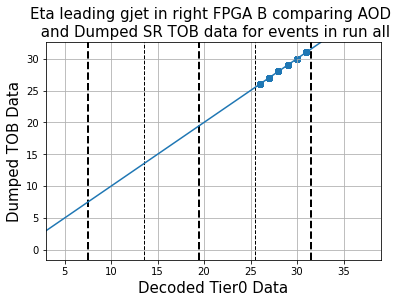

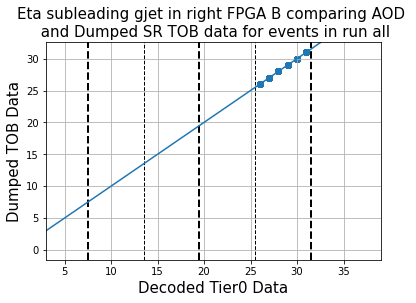

In [91]:
make_compare("Eta", "SR")

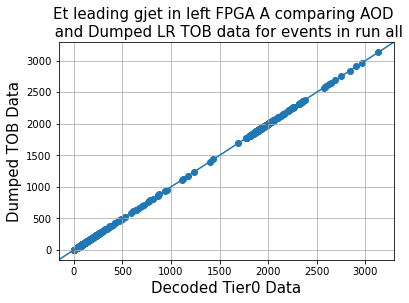

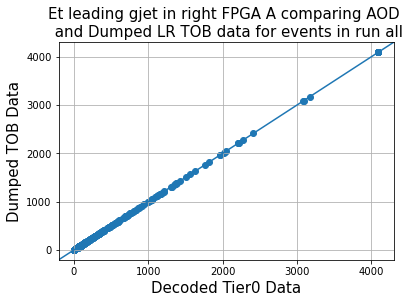

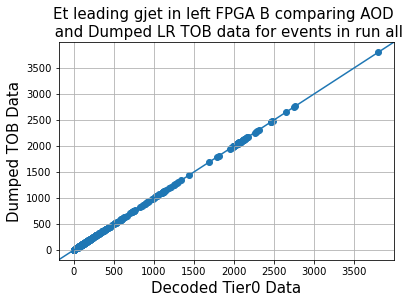

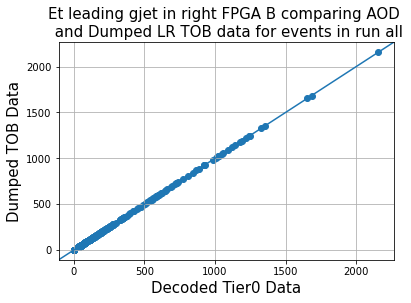

In [92]:
make_compare("Et", "LR")

In [93]:
# for e in range(num_events):
#     plot_2d(e, "SR")

In [94]:
# for e in range(num_events):
#     plot_2d(e, "LR")

In [95]:
# for e in range(num_events):
#     plot_lr_sr_2d(e)

In [96]:
print(num_events)

581
